# Training for Stylizer module
This notebook will handle the training the stylizer module.

## Load Pretrained model

In [ ]:
import matplotlib

matplotlib.use('Agg')

import os, sys
import yaml
from argparse import ArgumentParser
from time import gmtime, strftime
from shutil import copy

from frames_dataset import FramesDataset
from my_dataset import MyDataset

from modules.generator import OcclusionAwareGenerator # LCH: refer here for generator
from modules.discriminator import MultiScaleDiscriminator # LCH: refer here for discriminator
from modules.keypoint_detector import KPDetector # LCH: refer here for key point detector

import torch
import torch.nn.functional as F

from train import train # LCH: For training process, everything in this module
from reconstruction import reconstruction
from animate import animate

In [ ]:
config_path = "config/anim-256.yaml"
with open(config_path) as f:
        # read in the config file
        config = yaml.load(f) # config file contains code directions, including training details

checkpoint_path = "pre_trains/vox-cpk.pth.tar"
log_dir = "MyLog/"
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
# Copy the config file (*.yaml) into the logging path
if not os.path.exists(os.path.join(log_dir, os.path.basename(config_path))):
    copy(config_path, log_dir)

# initialize generator
generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
# initialize discriminator
discriminator = MultiScaleDiscriminator(**config['model_params']['discriminator_params'],
                                            **config['model_params']['common_params'])
# initialize kp detector
kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                             **config['model_params']['common_params'])

# If GPU Available, adapt to it
if torch.cuda.is_available():
    print("using GPU")
    generator.to(0)
    discriminator.to(0)
    kp_detector.to(0)

In [ ]:
# load in the pretrained modules
from logger import Logger

train_params = config['train_params']

if not torch.cuda.is_available():
    # remember to adapt to cpu version
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
else:
    checkpoint = torch.load(checkpoint_path)

generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])
kp_detector.load_state_dict(checkpoint['kp_detector'])

# The following models are used as data pre-processor
generator.eval()
discriminator.eval()
kp_detector.eval()

## Dataset Preparation

In [ ]:
from frames_dataset import DatasetRepeater
from torch.utils.data import DataLoader


# load original target data
frame_dataset = FramesDataset(is_train=True, **config['dataset_params'])
print("Dataset size: {}, repeat number: {}".format(len(frame_dataset), config['train_params']['num_repeats']))
# load source data
source_dataset = FramesDataset(is_train=True, **config['target_params'])
print("Dataset size: {}, repeat number: {}".format(len(source_dataset), config['train_params']['num_repeats']))
# load combined data
combine_dataset = MyDataset(source_dir=config['target_params']['root_dir'], target_dir=config['dataset_params']['root_dir'],
                            frame_shape=config['dataset_params']['frame_shape'], id_sampling=config['dataset_params']['id_sampling'],
                            is_train=True, augmentation_params=config['dataset_params']['augmentation_params'])
print("Dataset size: {}, repeat number: {}".format(len(combine_dataset), config['train_params']['num_repeats']))


if 'num_repeats' in train_params or train_params['num_repeats'] != 1:
    # Augment the dataset according to "num_reapeat"
    frame_dataset = DatasetRepeater(frame_dataset, train_params['num_repeats'])
    print("Repeated Target size: {}, repeat number: {}".format(len(frame_dataset), config['train_params']['num_repeats']))
    source_dataset = DatasetRepeater(source_dataset, train_params['num_repeats'])
    print("Repeated Source size: {}, repeat number: {}".format(len(source_dataset), config['train_params']['num_repeats']))
    combine_dataset = DatasetRepeater(combine_dataset, train_params['num_repeats'])
    print("Repeated Combin size: {}, repeat number: {}".format(len(combine_dataset), config['train_params']['num_repeats']))
    

targetLoader = DataLoader(frame_dataset, batch_size=train_params['batch_size'], shuffle=True, num_workers=2, drop_last=True)
sourceLoader = DataLoader(source_dataset, batch_size=train_params['batch_size'], shuffle=True, num_workers=2, drop_last=True)
combineLoader = DataLoader(combine_dataset, batch_size=train_params['batch_size'], shuffle=True, num_workers=2, drop_last=True)

In [ ]:
# declare a model
# declare objects needed by training process
from modules.stylizer import StylizerGenerator
from modules.stylizer_discriminator import StylizerDiscrim

# create network models
stylizer = StylizerGenerator(**config['model_params']['stylizer_params'])
styDiscrim = StylizerDiscrim(**config['model_params']['stylizerDiscrim_params'])

# create optimizers
lr_stylizer = 2.0e-4
lr_styDiscrim = 2.0e-4
optimizer_stylizer = torch.optim.Adam(stylizer.parameters(), lr=lr_stylizer, betas=(0.5, 0.999), weight_decay=1e-2)
optimizer_styDiscrim = torch.optim.Adam(styDiscrim.parameters(), lr=lr_styDiscrim, betas=(0.5, 0.999), weight_decay=1e-2)

# If GPU Available, adapt to it
if torch.cuda.is_available():
    print("using GPU")
    stylizer.to(0)
    styDiscrim.to(0)

In [ ]:
# Train following the GAN network process
from tqdm import trange
from my_logger import MyLogger

# read in the training parameters
stylize_params = config['stylize_params']

# declare a Logger
styLogger = MyLogger(log_dir, checkpoint_freq=stylize_params['checkpoint_freq'], log_file_name='log.txt')
# read in pre-trained results
checkpoint_path = None # TODO: set the checkpoint path if needed
if checkpoint_path:
    styLogger.load_cpk(checkpoint_path, stylizer, styDiscrim, optimizer_stylizer, optimizer_styDiscrim)

# check the dense motion module
if generator.dense_motion_network is None:
    print("Error: dense motion network doesn't exist!")
dm_network = generator.dense_motion_network # this model is used for extracting motion features
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# loop over
for epoch in trange(stylize_params['num_epochs']):
    for x in combineLoader:
        # -------------------------------  Data Preprocess  -------------------------------------#
        # first get the key points for both source and driving frames
        # Extract data of training data
        x['source'] = x['source'].to(device)    
        kp_source = kp_detector(x['source'])
        x['driving'] = x['driving'].to(device)
        kp_driving = kp_detector(x['driving'])
        # Extract data of target data
        x['t_source'] = x['t_source'].to(device)
        kp_t_source = kp_detector(x['t_source'])
        x['t_driving'] = x['t_driving'].to(device)
        kp_t_driving = kp_detector(x['t_driving'])

        # second pass through the motion predictor
        # plan A: get sparse motion as training data
        if dm_network.scale_factor != 1:
            src_image = dm_network.down(x['source'])
            tar_image = dm_network.down(x['t_source'])
        bs, _, h, w = src_image.shape
        sparse_motion = dm_network.create_sparse_motions(src_image, kp_driving, kp_source)
        sparse_motion_t = dm_network.create_sparse_motions(tar_image, kp_t_driving, kp_t_source) # motion from target data, serve as label
        # here we don't need the last key point, which is a identity grid layer added by users
        sparse_motion = sparse_motion[:, :-1, :, :, :] # The shape should be: torch.Size([10, 10, 64, 64, 2])
        sparse_motion_t = sparse_motion_t[:, :-1, :, :, :]
        orig_shape = sparse_motion.shape # record the orginal shape
        sparse_motion = sparse_motion.view((orig_shape[0], -1, orig_shape[2], orig_shape[3]))
        sparse_motion_t = sparse_motion_t.view((orig_shape[0], -1, orig_shape[2], orig_shape[3]))
        
        # -------------------------------  Loss Calculation  -------------------------------------#
        # pass in stylizer network
        loss_log = {}
        # calculate losses for stylizer
        stylized_dict = stylizer(sparse_motion.detach())
        loss_values = {}
        # for now, using MSE compared with original motion field, and GAN stylizer loss
        mse_loss = F.mse_loss(sparse_motion, stylized_dict['prediction'])
        loss_values['mse'] = mse_loss * stylize_params['loss_weights']['mse'] 
        # GAN stylizer loss
        # Compare real face data
        feature_real, discrim_real = styDiscrim(sparse_motion_t.detach()) # discriminate on target motion
        feature_gene, discrim_gene = styDiscrim(stylized_dict['prediction']) # discriminate on source motion
        gan_loss = ((1 - discrim_gene) ** 2).mean()
        loss_values['gan'] = gan_loss * stylize_params['loss_weights']['gan'] 
        # TODO: consider add feature matching loss
        # Not suitable for this case, there's no one vs one correspondence between two data
        if stylize_params['loss_weights']['match'] != 0:
            value_total = 0
            for i, (a, b) in enumerate(zip(feature_real, feature_gene)):
                # calculate feature matching loss for each scale
                value = torch.abs(a - b).mean()
                value_total += value
            loss_values['match'] = value_total * stylize_params['loss_weights']['match']
        # Now combine all loss values for stylizer, update stylizer
        loss_log.update(loss_values) # this is for logging
        loss = sum([val.mean() for val in loss_values.values()])
        loss.backward()
        optimizer_stylizer.step()
        optimizer_stylizer.zero_grad()
        
        # Now deal with discriminator training
        loss_values = {}
        optimizer_styDiscrim.zero_grad()
        _, discrim_real = styDiscrim(sparse_motion_t.detach()) # data that should be judged as True
        _, discrim_gene = styDiscrim(stylized_dict['prediction'].detach()) # data that should be judged as False
        discrim_loss = (1 - discrim_real) ** 2 + discrim_gene ** 2
        loss_values['discrim'] = discrim_loss.mean() * stylize_params['loss_weights']['discrim']
        # combine losses for stylizer discriminator, update discriminator
        loss_log.update(loss_values) # this is for logging
        loss = sum([val.mean() for val in loss_values.values()])
        loss.backward()
        optimizer_styDiscrim.step()
        optimizer_styDiscrim.zero_grad()
        
        # End of iteration, do logging
        loss_log = {key: value.mean().detach().data.cpu().numpy() for key, value in loss_log.items()}
        styLogger.log_iter(losses=loss_log)
        
    # End of an epoch, do logging
    styLogger.log_epoch(epoch, 
                        {'stylizer': stylizer, 'styDiscrim': styDiscrim, 'optimizer_stylizer': optimizer_stylizer, 'optimizer_styDiscrim': optimizer_styDiscrim}, 
                        orig_shape, sparse_motion, stylized_dict['prediction'])

# End of training, do logging
styLogger.plot_scores()
styLogger.save_cpk()

## Model Embedding

## Code snippets part

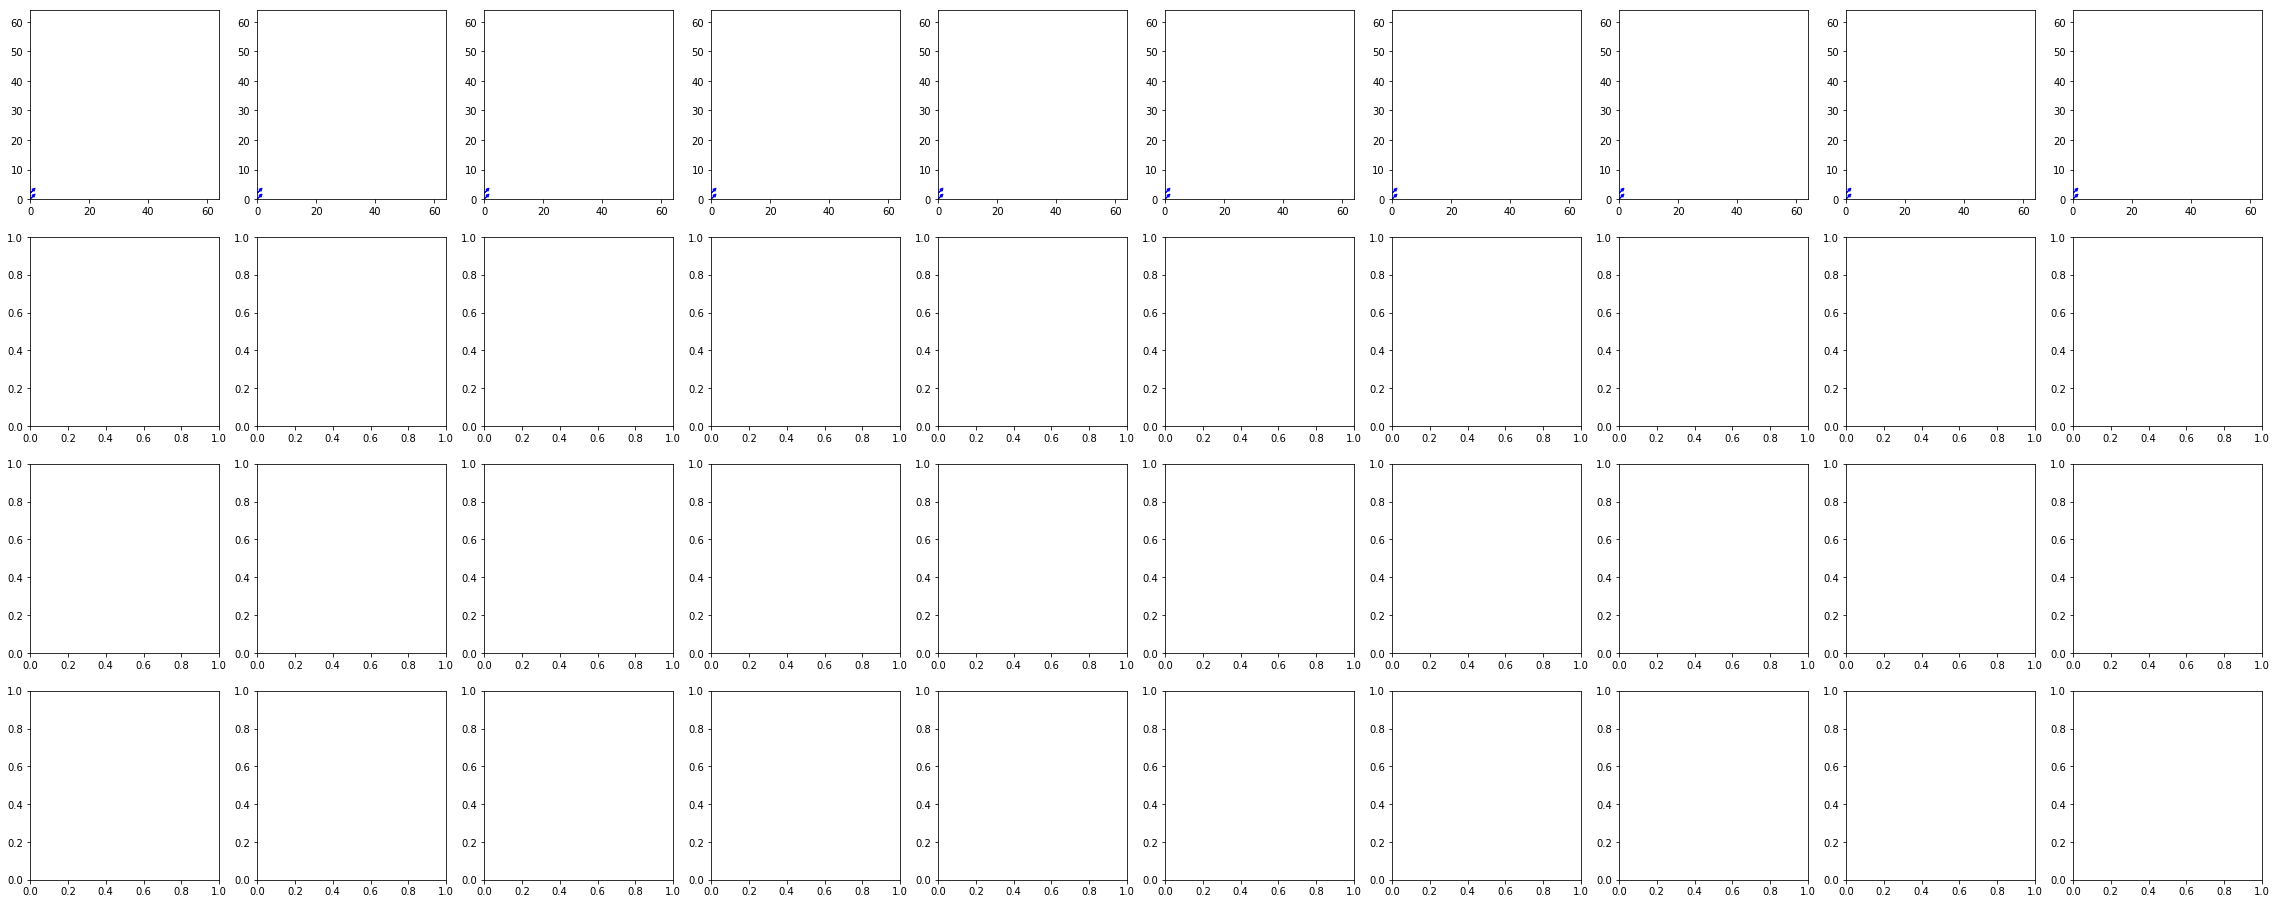

In [41]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 10, figsize=(40, 16))

for ax in axes[0]:
    ax.set_xlim(0, 64)
    ax.set_ylim(0, 64)
    
    v = np.array([1, 1])
    ax.arrow(0, 0, *v, color='b', linewidth=1.0, head_width=1.0, head_length=1)
    ax.arrow(0, 2, *v, color='b', linewidth=1.0, head_width=1.0, head_length=1)
    
plt.show()

In [ ]:
h, w = 4, 4
x = torch.arange(w).type(torch.float)
y = torch.arange(h).type(torch.float)

x = (2 * (x / (w - 1)) - 1)
y = (2 * (y / (h - 1)) - 1)

yy = y.view(-1, 1).repeat(1, w)
xx = x.view(1, -1).repeat(h, 1)

meshed = torch.cat([xx.unsqueeze_(2), yy.unsqueeze_(2)], 2)

print(meshed.shape)

meshed = meshed.view(1, 1, h, w, 2)
meshed.shape